In [1]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

import numpy as np

# preds

# Load the training set of meta-model
delaney_chemberta2_valid2 = pd.read_csv('./chemberta2/results/delaney/chemberta2_valid2_delaney_3_predictions.csv')
delaney_molformer_valid2 = pd.read_csv('./molformer/results/delaney/molformer_valid2_delaney_3_99.csv')
delaney_molbert_valid2 = pd.read_csv('./molbert/results/delaney/molbert_valid2_delaney_3.csv')

# Load the test data for each model
delaney_chemberta2_test = pd.read_csv('./chemberta2/results/delaney/chemberta2_test_delaney_3_predictions.csv')
delaney_molformer_test = pd.read_csv('./molformer/results/delaney/molformer_test_delaney_3_99.csv')
delaney_molbert_test = pd.read_csv('./molbert/results/delaney/molbert_test_delaney_3.csv')

train_mean = -3.0955443786982246
train_sd = 2.121246879189704

# features

# Load the features from chemberta
delaney_chemberta2_features_valid2 = pd.read_csv('./chemberta2/features/delaney/chemberta2_valid2_delaney_3_features.csv')
delaney_chemberta2_features_test = pd.read_csv('./chemberta2/features/delaney/chemberta2_test_delaney_3_features.csv')

# Load the features from molformer
delaney_molformer_features_valid2 = pd.read_csv('./molformer/features/delaney/molformer_valid2_delaney_3_features.csv')
delaney_molformer_features_test = pd.read_csv('./molformer/features/delaney/molformer_test_delaney_3_features.csv')

# Load the features from molbert
delaney_molbert_features_valid2 = pd.read_csv('./molbert/features/delaney/molbert_valid2_delaney_3_features.csv')
delaney_molbert_features_test = pd.read_csv('./molbert/features/delaney/molbert_test_delaney_3_features.csv')

For delaney (regression)

In [2]:
# Preparing the actual and predicted values
# Chemberta2
delaney_chemberta_actual = delaney_chemberta2_test['target'] 
delaney_chemberta_pred = delaney_chemberta2_test['pred_raw']

# Molformer
delaney_molformer_actual = delaney_molformer_test['target']
delaney_molformer_pred = delaney_molformer_test['pred_raw']

# molbert
delaney_molbert_actual = delaney_molbert_test['target_raw']
delaney_molbert_pred = delaney_molbert_test['pred_raw']

In [3]:
# Calculating metrics
delaney_metrics_results = {}

for model_name, actual, pred in [("Chemberta2", delaney_chemberta_actual, delaney_chemberta_pred),
                                 ("Molformer", delaney_molformer_actual, delaney_molformer_pred),
                                 ("Molbert", delaney_molbert_actual, delaney_molbert_pred)]:
    delaney_metrics_results[model_name] = {
        "MAE": mean_absolute_error(actual, pred),
        "RMSE": np.sqrt(mean_squared_error(actual, pred)),
        "R2 Score": r2_score(actual, pred),
        "Correlation": pearsonr(actual, pred)[0]  # Only record the correlation coefficient
    }

delaney_metrics_results

{'Chemberta2': {'MAE': 0.5606664320638193,
  'RMSE': 0.7305590849172536,
  'R2 Score': 0.8573821186737384,
  'Correlation': 0.9294289768725041},
 'Molformer': {'MAE': 0.4865245807831858,
  'RMSE': 0.662620137396756,
  'R2 Score': 0.8826744633917042,
  'Correlation': 0.9422375703567979},
 'Molbert': {'MAE': 0.5384853131061946,
  'RMSE': 0.6906433653118413,
  'R2 Score': 0.8725408620066292,
  'Correlation': 0.9387197751694946}}

In [4]:
# Create the features for the ensemble from the prediction probabilities of being in class 1
delaney_X_ensemble_valid2 = pd.concat([
    delaney_chemberta2_valid2['pred_z'],
    delaney_molformer_valid2['pred_z'], 
    delaney_molbert_valid2['pred_z'],
    # add features from training set
    delaney_chemberta2_features_valid2.iloc[:, 2:],
    delaney_molformer_features_valid2.iloc[:, 1:],
    delaney_molbert_features_valid2.iloc[:, 1:]
], axis=1)

# change feature names of the ensemble so that they are unique
delaney_X_ensemble_valid2.columns = ['chemberta', 'molformer', 'molbert'] + list(delaney_chemberta2_features_valid2.columns[2:]) + list(delaney_molformer_features_valid2.columns[1:]) + list(delaney_molbert_features_valid2.columns[1:])

# Use the actual labels from any of the models (assuming they are all the same across datasets)
delaney_y_ensemble_valid2 = (delaney_chemberta2_valid2['target'] - train_mean)/train_sd

delaney_X_ensemble_test = pd.concat([
    delaney_chemberta2_test['pred_z'],
    delaney_molformer_test['pred_z'],  
    delaney_molbert_test['pred_z'],
    # add features from test set
    delaney_chemberta2_features_test.iloc[:, 2:],
    delaney_molformer_features_test.iloc[:, 1:],
    delaney_molbert_features_test.iloc[:, 1:]
], axis=1)

# change feature names of the ensemble so that they are unique
delaney_X_ensemble_test.columns = ['chemberta', 'molformer', 'molbert'] + list(delaney_chemberta2_features_test.columns[2:]) + list(delaney_molformer_features_test.columns[1:]) + list(delaney_molbert_features_test.columns[1:])

# Use the actual labels from any of the models (assuming they are all the same across datasets)
delaney_y_ensemble_test = delaney_chemberta2_test['target']

In [5]:
# min-max scaling using minmaxscaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# delaney_X_ensemble_valid2_scaled = scaler.fit_transform(delaney_X_ensemble_valid2)
# delaney_X_ensemble_test_scaled = scaler.transform(delaney_X_ensemble_test)

# # convert back to dataframe
# delaney_X_ensemble_valid2_scaled = pd.DataFrame(delaney_X_ensemble_valid2_scaled, columns=delaney_X_ensemble_valid2.columns)
# delaney_X_ensemble_test_scaled = pd.DataFrame(delaney_X_ensemble_test_scaled, columns=delaney_X_ensemble_test.columns)

In [6]:
# scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
delaney_X_ensemble_valid2_scaled = scaler.fit_transform(delaney_X_ensemble_valid2)
delaney_X_ensemble_test_scaled = scaler.transform(delaney_X_ensemble_test)

delaney_X_ensemble_valid2_scaled = pd.DataFrame(delaney_X_ensemble_valid2_scaled, columns=delaney_X_ensemble_valid2.columns)
delaney_X_ensemble_test_scaled = pd.DataFrame(delaney_X_ensemble_test_scaled, columns=delaney_X_ensemble_test.columns)

In [7]:
# lasso model
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the LassoCV model
lasso_cv = LassoCV(cv=5, max_iter = 5000, random_state=0)

# Fit the model
lasso_cv.fit(delaney_X_ensemble_valid2_scaled, delaney_y_ensemble_valid2)

# Predict the test set
delaney_lasso_pred = lasso_cv.predict(delaney_X_ensemble_test_scaled) * train_sd + train_mean

# Calculate the metrics
delaney_lasso_metrics = {
    "MAE": mean_absolute_error(delaney_y_ensemble_test, delaney_lasso_pred),
    "RMSE": np.sqrt(mean_squared_error(delaney_y_ensemble_test, delaney_lasso_pred)),
    "R2 Score": r2_score(delaney_y_ensemble_test, delaney_lasso_pred),
    "Correlation": pearsonr(delaney_y_ensemble_test, delaney_lasso_pred)[0]
}

delaney_lasso_metrics

{'MAE': 0.4576164699868116,
 'RMSE': 0.6289976742212688,
 'R2 Score': 0.8942789742916649,
 'Correlation': 0.9476553298789084}

In [8]:
# use lasso to select features
coefs = pd.Series(lasso_cv.coef_, index=delaney_X_ensemble_valid2.columns)

selected_features = coefs[coefs != 0].index.tolist()

print("Selected Features:", selected_features)

chemberta_count = sum('chemberta' in feature for feature in selected_features)
molformer_count = sum('molformer' in feature for feature in selected_features)
molbert_count = sum('molbert' in feature for feature in selected_features)

print("Chemberta2 count:", chemberta_count)
print("Molformer count:", molformer_count)
print("Molbert count:", molbert_count)

Selected Features: ['chemberta', 'molformer', 'molbert', 'molbert_features_742']
Chemberta2 count: 1
Molformer count: 1
Molbert count: 2


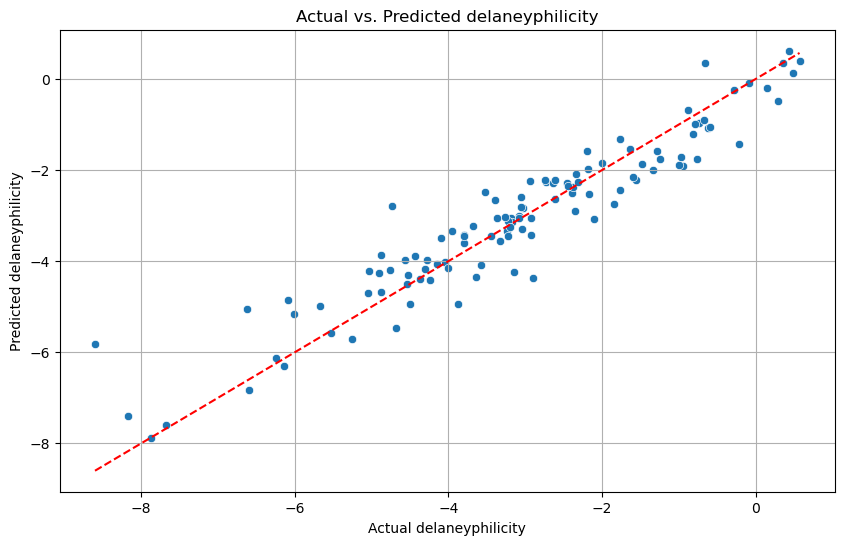

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=delaney_y_ensemble_test, y=delaney_lasso_pred)
plt.title('Actual vs. Predicted delaneyphilicity')
plt.xlabel('Actual delaneyphilicity')
plt.ylabel('Predicted delaneyphilicity')
plt.plot([min(delaney_y_ensemble_test), max(delaney_y_ensemble_test)], [min(delaney_y_ensemble_test), max(delaney_y_ensemble_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.grid(True)
plt.show()


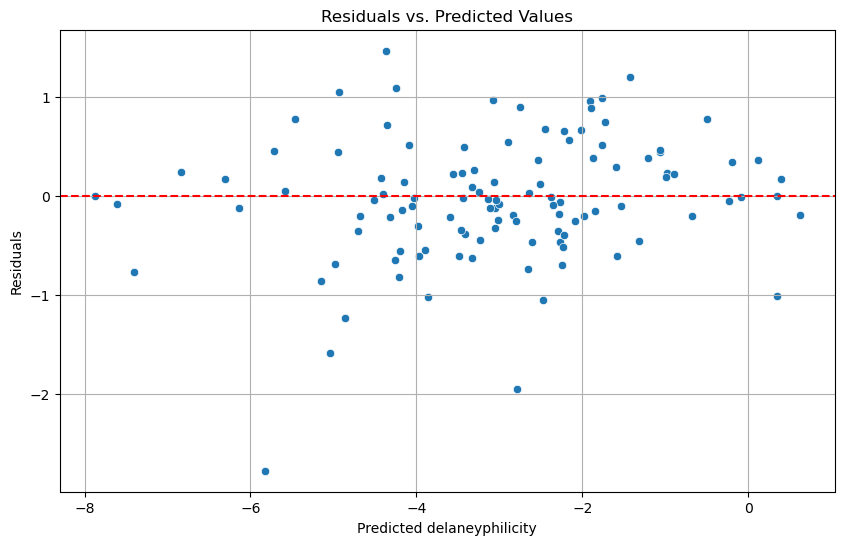

In [10]:
# Calculate residuals
residuals = delaney_y_ensemble_test - delaney_lasso_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=delaney_lasso_pred, y=residuals)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted delaneyphilicity')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()


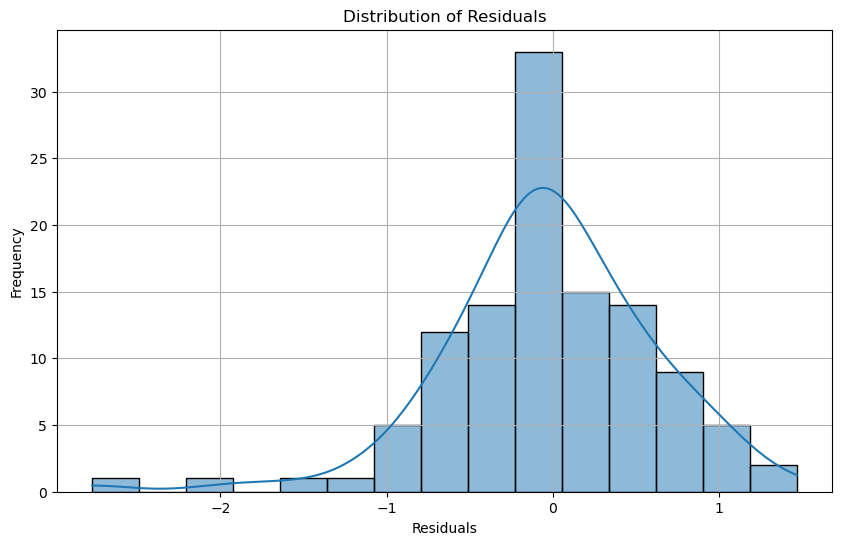

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
# elastic net
# Define the model with elasticnet penalty for regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

elastic_net_model = ElasticNet(random_state=0, max_iter=5000)

# Define the hyperparameter grid
# Use fewer discrete values for alpha and l1_ratio
alphas = [0.01, 0.1, 1, 3]  # Reduced number of points focusing on lower and mid-range
l1_ratios = [0.1, 0.5, 0.9]  # Reduced to three points, emphasizing edges and midpoint

params = {
    'alpha': alphas,  # Convert alpha back to C
    'l1_ratio': l1_ratios
}

grid_search = GridSearchCV(elastic_net_model, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(delaney_X_ensemble_valid2_scaled, delaney_y_ensemble_valid2)

# Get the best hyperparameters
delaney_best_elastic_params = grid_search.best_params_
print(delaney_best_elastic_params)

# Initialize and train the best ElasticNet model
delaney_best_elastic_model = ElasticNet(alpha=delaney_best_elastic_params['alpha'], l1_ratio=delaney_best_elastic_params['l1_ratio'], random_state=0, max_iter=5000)
delaney_best_elastic_model.fit(delaney_X_ensemble_valid2_scaled, delaney_y_ensemble_valid2)

# Predict the test set
delaney_elastic_pred = delaney_best_elastic_model.predict(delaney_X_ensemble_test_scaled) * train_sd + train_mean

# Calculate the metrics
delaney_elastic_metrics = {
    "MAE": mean_absolute_error(delaney_y_ensemble_test, delaney_elastic_pred),
    "RMSE": np.sqrt(mean_squared_error(delaney_y_ensemble_test, delaney_elastic_pred)),
    "R2 Score": r2_score(delaney_y_ensemble_test, delaney_elastic_pred),
    "Correlation": pearsonr(delaney_y_ensemble_test, delaney_elastic_pred)[0]
}

delaney_elastic_metrics

{'alpha': 0.1, 'l1_ratio': 0.9}


{'MAE': 0.46653177940320456,
 'RMSE': 0.6396178543291641,
 'R2 Score': 0.8906787861762007,
 'Correlation': 0.9475629277664109}

In [13]:
# use elastic net to select features
coefs = pd.Series(delaney_best_elastic_model.coef_, index=delaney_X_ensemble_valid2.columns)

selected_features = coefs[coefs != 0].index.tolist()

print("Selected Features:", selected_features)

chemberta_count = sum('chemberta' in feature for feature in selected_features)
molformer_count = sum('molformer' in feature for feature in selected_features)
molbert_count = sum('molbert' in feature for feature in selected_features)

print("Chemberta2 count:", chemberta_count)
print("Molformer count:", molformer_count)
print("Molbert count:", molbert_count)

Selected Features: ['chemberta', 'molformer', 'molbert']
Chemberta2 count: 1
Molformer count: 1
Molbert count: 1


In [14]:
# # use elastic net to select features
# coefs = pd.Series(delaney_best_elastic_model.coef_, index=delaney_X_ensemble_valid2.columns)

# selected_features = coefs[coefs != 0].index.tolist()
# delaney_X_ensemble_valid2_selected = delaney_X_ensemble_valid2_scaled[selected_features]
# delaney_X_ensemble_test_selected = delaney_X_ensemble_test_scaled[selected_features]

# # check if chemberta, molformer, molbert are selected, if not, add them, use a loop
# for feature in ['chemberta', 'molformer', 'molbert']:
#     if feature not in selected_features:
#         delaney_X_ensemble_valid2_selected[feature] = delaney_X_ensemble_valid2_scaled[feature]
#         delaney_X_ensemble_test_selected[feature] = delaney_X_ensemble_test_scaled[feature]

# print("Selected Features:", selected_features)
# print("Filtered Dataset Shape:", delaney_X_ensemble_valid2_selected.shape)

# # check how many features have Chemberta2, Molformer, Molbert
# selected_features = delaney_X_ensemble_valid2_selected.columns
# chemberta_count = sum('chemberta' in feature for feature in selected_features)
# molformer_count = sum('molformer' in feature for feature in selected_features)
# molbert_count = sum('molbert' in feature for feature in selected_features)

# print("Chemberta2 count:", chemberta_count)
# print("Molformer count:", molformer_count)
# print("Molbert count:", molbert_count)

Selected Features: ['chemberta', 'molformer', 'molbert']
Filtered Dataset Shape: (226, 3)
Chemberta2 count: 1
Molformer count: 1
Molbert count: 1


In [24]:
# use lasso to select features
coefs = pd.Series(lasso_cv.coef_, index=delaney_X_ensemble_valid2.columns)

selected_features = coefs[coefs != 0].index.tolist()
delaney_X_ensemble_valid2_selected = delaney_X_ensemble_valid2_scaled[selected_features]
delaney_X_ensemble_test_selected = delaney_X_ensemble_test_scaled[selected_features]

# check if chemberta, molformer, molbert are selected, if not, add them, use a loop
for feature in ['chemberta', 'molformer', 'molbert']:
    if feature not in selected_features:
        delaney_X_ensemble_valid2_selected[feature] = delaney_X_ensemble_valid2_scaled[feature]
        delaney_X_ensemble_test_selected[feature] = delaney_X_ensemble_test_scaled[feature]

print("Selected Features:", selected_features)
print("Filtered Dataset Shape:", delaney_X_ensemble_valid2_selected.shape)

# check how many features have Chemberta2, Molformer, Molbert
selected_features = delaney_X_ensemble_valid2_selected.columns
chemberta_count = sum('chemberta' in feature for feature in selected_features)
molformer_count = sum('molformer' in feature for feature in selected_features)
molbert_count = sum('molbert' in feature for feature in selected_features)

print("Chemberta2 count:", chemberta_count)
print("Molformer count:", molformer_count)
print("Molbert count:", molbert_count)

Selected Features: ['chemberta', 'molformer', 'molbert', 'molbert_features_742']
Filtered Dataset Shape: (226, 4)
Chemberta2 count: 1
Molformer count: 1
Molbert count: 2


In [25]:
# delaney_X_ensemble_valid2_selected = delaney_X_ensemble_valid2_scaled[selected_features]
# delaney_X_ensemble_test_selected = delaney_X_ensemble_test_scaled[selected_features]

# check shapes
print(delaney_X_ensemble_valid2_selected.shape)
print(delaney_X_ensemble_test_selected.shape)

(226, 4)
(113, 4)


In [26]:
# Initialize and train the SVR model
from sklearn.svm import SVR

delaney_svr_model = SVR()
delaney_svr_model.fit(delaney_X_ensemble_valid2_selected, delaney_y_ensemble_valid2)

# Predict the test set
delaney_svr_pred = delaney_svr_model.predict(delaney_X_ensemble_test_selected) * train_sd + train_mean

# Calculate the metrics
delaney_svr_metrics = {
    "MAE": mean_absolute_error(delaney_y_ensemble_test, delaney_svr_pred ),
    "RMSE": np.sqrt(mean_squared_error(delaney_y_ensemble_test, delaney_svr_pred )),
    "R2 Score": r2_score(delaney_y_ensemble_test, delaney_svr_pred ),
    "Correlation": pearsonr(delaney_y_ensemble_test, delaney_svr_pred )[0]  # Only record the correlation coefficient
}

delaney_svr_metrics

{'MAE': 0.46200765557083046,
 'RMSE': 0.612554816985031,
 'R2 Score': 0.8997341112748715,
 'Correlation': 0.9488731661153723}

In [27]:
# initailize and use a 5-fold cross-validation to tune the hyperparameters of a random forest model for regression
from sklearn.ensemble import RandomForestRegressor

delaney_rf_model = RandomForestRegressor(random_state=0)

delaney_rf_model.fit(delaney_X_ensemble_valid2_selected, delaney_y_ensemble_valid2)

# Predict the test set
delaney_rf_best_pred = delaney_rf_model.predict(delaney_X_ensemble_test_selected) * train_sd + train_mean

# Calculate the metrics
delaney_rf_best_metrics = {
    "MAE": mean_absolute_error(delaney_y_ensemble_test, delaney_rf_best_pred),
    "RMSE": np.sqrt(mean_squared_error(delaney_y_ensemble_test, delaney_rf_best_pred)),
    "R2 Score": r2_score(delaney_y_ensemble_test, delaney_rf_best_pred),
    "Correlation": pearsonr(delaney_y_ensemble_test, delaney_rf_best_pred)[0]  # Only record the correlation coefficient
}

delaney_rf_best_metrics

{'MAE': 0.4696678761061949,
 'RMSE': 0.6350097806458804,
 'R2 Score': 0.8922483032113101,
 'Correlation': 0.945147897252556}

In [28]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.early_stop import no_progress_loss

# Define the hyperparameter space using continuous distributions
delaney_xgb_hyperopt_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 50),
    'max_depth': hp.quniform('max_depth', 3, 7, 2),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

# Correctly define the RMSE scorer function
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Convert float outputs of hp.quniform to int for certain parameters
def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    model = xgb.XGBRegressor(**params, random_state=0)
    
    # Cross-validated RMSE as the objective
    score = cross_val_score(model, delaney_X_ensemble_valid2_selected, delaney_y_ensemble_valid2, 
                            scoring=make_scorer(rmse_scorer, greater_is_better=False), cv=5)
    
    # Minimize the positive RMSE (already negative from scoring)
    return {'loss': -score.mean(), 'status': STATUS_OK}

# Run the Bayesian optimization
trials = Trials()
delaney_xgb_best_params = fmin(fn=objective, 
                            space=delaney_xgb_hyperopt_space, 
                            algo=tpe.suggest, 
                            max_evals=100, 
                            trials=trials,
                            early_stop_fn=no_progress_loss(10))

print("Best hyperparameters:", delaney_xgb_best_params)


 19%|█▉        | 19/100 [00:09<00:39,  2.04trial/s, best loss: 0.2907066655475409]
Best hyperparameters: {'colsample_bytree': 0.9287544344072483, 'learning_rate': 0.035279992449831654, 'max_depth': 6.0, 'n_estimators': 100.0, 'subsample': 0.8176690917438335}


In [29]:
# fit the model with the best hyperparameters
# Convert parameters obtained from Hyperopt to the correct data type
delaney_xgb_best_params['n_estimators'] = int(delaney_xgb_best_params['n_estimators'])
delaney_xgb_best_params['max_depth'] = int(delaney_xgb_best_params['max_depth'])

# Initialize and train the XGBoost model with the best parameters
delaney_xgb_model = xgb.XGBRegressor(**delaney_xgb_best_params, random_state=0)
delaney_xgb_model.fit(delaney_X_ensemble_valid2_selected, delaney_y_ensemble_valid2)

# Predict the test set
delaney_xgb_best_pred = delaney_xgb_model.predict(delaney_X_ensemble_test_selected) * train_sd + train_mean

# Calculate the metrics
delaney_xgb_best_metrics = {
    "MAE": mean_absolute_error(delaney_y_ensemble_test, delaney_xgb_best_pred),
    "RMSE": np.sqrt(mean_squared_error(delaney_y_ensemble_test, delaney_xgb_best_pred)),
    "R2 Score": r2_score(delaney_y_ensemble_test, delaney_xgb_best_pred),
    "Correlation": pearsonr(delaney_y_ensemble_test, delaney_xgb_best_pred)[0]  # Only record the correlation coefficient
}

delaney_xgb_best_metrics

{'MAE': 0.48798045210711727,
 'RMSE': 0.6479846230960427,
 'R2 Score': 0.8878000434147256,
 'Correlation': 0.942405867308102}

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.early_stop import no_progress_loss

torch.manual_seed(0)

# Define RMSE loss
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

# Define the neural network model for regression
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_layers, num_neurons, dropout_rate):
        super(SimpleNN, self).__init__()
        layers = [nn.Linear(input_size, num_neurons), nn.ReLU(), nn.Dropout(dropout_rate)]
        
        for _ in range(1, num_layers):
            layers += [nn.Linear(num_neurons, num_neurons), nn.ReLU(), nn.Dropout(dropout_rate)]
        
        layers += [nn.Linear(num_neurons, 1)]
        
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

# Hyperparameter space with hp.quniform for integer distribution
space = {
    'num_layers': hp.quniform('num_layers', 1, 5, 1),
    'num_neurons': hp.quniform('num_neurons', 16, 256, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.5)
}

# Global dataset variables assumed to be defined externally
X = delaney_X_ensemble_valid2_selected
y = delaney_y_ensemble_valid2

# Objective function for Bayesian optimization
def objective(params):
    params['num_layers'] = int(params['num_layers'])  # Ensure num_layers is an integer
    params['num_neurons'] = int(params['num_neurons'])  # Ensure num_neurons is an integer
    kf = KFold(n_splits=5)
    rmse_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Convert DataFrame to numpy arrays before making them PyTorch tensors
        train_dataset = TensorDataset(torch.tensor(X_train.values.astype(np.float32)), 
                                      torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        model = SimpleNN(input_size=X_train.shape[1], num_layers=params['num_layers'],
                         num_neurons=params['num_neurons'], dropout_rate=params['dropout_rate'])
        criterion = RMSELoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        model.train()
        for epoch in range(100):
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(torch.tensor(X_val.values.astype(np.float32))).squeeze(1)
            val_targets = torch.tensor(y_val.values.astype(np.float32))
            rmse = np.sqrt(mean_squared_error(val_targets.numpy(), val_preds.numpy()))
            rmse_scores.append(rmse)

    avg_rmse = np.mean(rmse_scores)
    return {'loss': avg_rmse, 'status': STATUS_OK} # Minimize RMSE

# Run Bayesian optimization
trials = Trials()
delaney_nn_best_params = fmin(fn=objective,
                           space=space,
                           algo=tpe.suggest,
                           max_evals=50,
                           trials=trials,
                           early_stop_fn=no_progress_loss(10))

print("Best hyperparameters:", delaney_nn_best_params)


 26%|██▌       | 13/50 [01:06<03:10,  5.15s/trial, best loss: 0.27685537934303284]
Best hyperparameters: {'dropout_rate': 0.46719428458648354, 'learning_rate': 0.00015869057175444767, 'num_layers': 2.0, 'num_neurons': 84.0}


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

torch.manual_seed(0)

# Define the neural network model again
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_layers, num_neurons, dropout_rate):
        super(SimpleNN, self).__init__()
        layers = [nn.Linear(input_size, num_neurons), nn.ReLU(), nn.Dropout(dropout_rate)]
        
        for _ in range(1, num_layers):
            layers += [nn.Linear(num_neurons, num_neurons), nn.ReLU(), nn.Dropout(dropout_rate)]
        
        layers += [nn.Linear(num_neurons, 1)]
        
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

# Define a function to compute RMSE
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Convert parameters to the correct format if necessary
delaney_nn_best_params = {
    'num_layers':  int(delaney_nn_best_params['num_layers']),  # Extracted from Bayesian optimization results
    'num_neurons':  int(delaney_nn_best_params['num_neurons']),  # Extracted from Bayesian optimization results
    'dropout_rate': delaney_nn_best_params['dropout_rate'],  # Extracted from Bayesian optimization results
    'learning_rate': delaney_nn_best_params['learning_rate']  # Extracted from Bayesian optimization results
}

# Prepare datasets
X_train_tensor = torch.tensor(delaney_X_ensemble_valid2_selected.values.astype(np.float32))
y_train_tensor = torch.tensor(delaney_y_ensemble_valid2.values.astype(np.float32)).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test_tensor = torch.tensor(delaney_X_ensemble_test_selected.values.astype(np.float32))
y_test_tensor = torch.tensor(delaney_y_ensemble_test.values.astype(np.float32)).unsqueeze(1)

# Initialize the model
model = SimpleNN(input_size=delaney_X_ensemble_valid2_selected.shape[1], num_layers=delaney_nn_best_params['num_layers'],
                         num_neurons=delaney_nn_best_params['num_neurons'], dropout_rate=delaney_nn_best_params['dropout_rate'])
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=delaney_nn_best_params['learning_rate'])

# Training loop
model.train()
for epoch in range(100):  # Number of epochs can be adjusted
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = outputs.squeeze(1).numpy() * train_sd + train_mean

    # Calculate metrics
    mae = mean_absolute_error(y_test_tensor.numpy(), predictions)
    rmse = compute_rmse(y_test_tensor.numpy(), predictions)
    r2 = r2_score(y_test_tensor.numpy(), predictions)
    correlation, _ = pearsonr(y_test_tensor.numpy().squeeze(1), predictions)

    delaney_nn_metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'R2 Score': r2,
        'Correlation': correlation
    }

delaney_nn_metrics

{'MAE': 0.46931145,
 'RMSE': 0.63810885,
 'R2 Score': 0.8911939979923842,
 'Correlation': 0.9465405062121688}

In [32]:
# create a table to record all metrics for delaney
delaney_metrics_results["Elastic Net"] = delaney_elastic_metrics
delaney_metrics_results["LASSO"] = delaney_lasso_metrics
delaney_metrics_results["SVR"] = delaney_svr_metrics
delaney_metrics_results["Random Forest"] = delaney_rf_best_metrics
delaney_metrics_results["XGBoost"] = delaney_xgb_best_metrics
delaney_metrics_results["Neural Network"] = delaney_nn_metrics

delaney_metrics_df = pd.DataFrame(delaney_metrics_results).T
# keep 3 digits after the decimal point
delaney_metrics_df = delaney_metrics_df.round(3)

# export table to csv
delaney_metrics_df.to_csv('./split3_delaney_metrics_lassoFeatures.csv')